In [1]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
data_set = "2014-2015.csv" 
df = pd.read_csv(data_set)
print(df.shape)
print(df.columns)

(5197, 15)
Index(['reference_number', 'grid_ref_easting', 'grid_ref_northing',
       'number_of_vehicles', 'accident_date', 'time_24hr', '1st_road_class',
       'road_surface', 'lighting_conditions', 'weather_conditions',
       'casualty_class', 'casualty_severity', 'sex_of_casualty',
       'age_of_casualty', 'type_of_vehicle'],
      dtype='object')


In [2]:
duplicate_rows = df[df.duplicated()]
df = df.drop_duplicates()
df['road_surface'].fillna(df['road_surface'].mode()[0], inplace=True)
print(df.isna().sum())
columns_to_remove = ['reference_number', 'grid_ref_easting', 'grid_ref_northing']
df = df.drop(columns=columns_to_remove)

reference_number       0
grid_ref_easting       0
grid_ref_northing      0
number_of_vehicles     0
accident_date          0
time_24hr              0
1st_road_class         0
road_surface           0
lighting_conditions    0
weather_conditions     0
casualty_class         0
casualty_severity      0
sex_of_casualty        0
age_of_casualty        0
type_of_vehicle        0
dtype: int64


In [3]:
df = pd.get_dummies(df, columns=['1st_road_class', 'lighting_conditions', 'weather_conditions', 'casualty_class', 'sex_of_casualty', 'type_of_vehicle'], drop_first=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['age_of_casualty', 'number_of_vehicles']] = scaler.fit_transform(df[['age_of_casualty', 'number_of_vehicles']])


In [5]:
df['accident_date'] = pd.to_datetime(df['accident_date'])

df['day_of_week'] = df['accident_date'].dt.dayofweek
df['month'] = df['accident_date'].dt.month
df['hour_of_day'] = df['time_24hr'] // 100

In [6]:
df = df.drop(columns=['accident_date', 'time_24hr'])

df = df.drop(columns=['road_surface'])

In [7]:
print(df.describe())
print(df['casualty_severity'].value_counts())

       number_of_vehicles  age_of_casualty  1st_road_class_A(M)  \
count         5156.000000      5156.000000          5156.000000   
mean             0.130721         0.359668             0.019977   
std              0.109827         0.193449             0.139934   
min              0.000000         0.000000             0.000000   
25%              0.000000         0.218750             0.000000   
50%              0.142857         0.322917             0.000000   
75%              0.142857         0.479167             0.000000   
max              1.000000         1.000000             1.000000   

       1st_road_class_B  1st_road_class_C  1st_road_class_Motorway  \
count       5156.000000       5156.000000              5156.000000   
mean           0.046354          0.003297                 0.059736   
std            0.210270          0.057331                 0.237020   
min            0.000000          0.000000                 0.000000   
25%            0.000000          0.000000     

Distribution of Casualty Severity:
Slight     4483
Serious     634
Fatal        39
Name: casualty_severity, dtype: int64


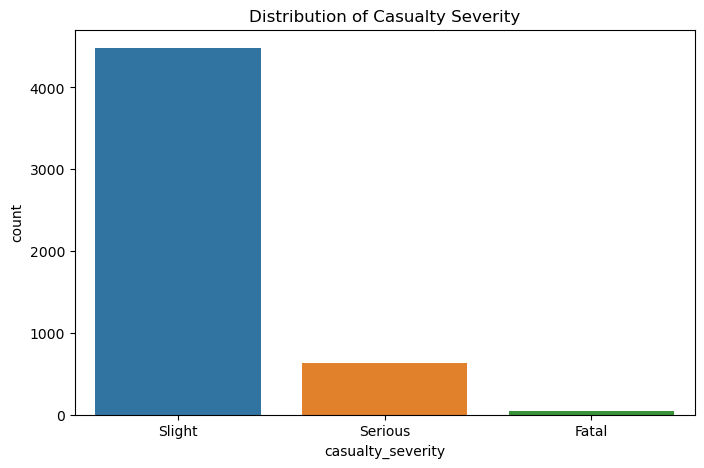

In [8]:
target_variable = 'casualty_severity'

severity_distribution = df[target_variable].value_counts()
print("Distribution of Casualty Severity:")
print(severity_distribution)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=target_variable, data=df)
plt.title("Distribution of Casualty Severity")
plt.show()


In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target_variable])
y = df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Distribution after oversampling:")
print(pd.Series(y_resampled).value_counts())
data = {
    'Dataset': ['Original', 'Training Set', 'Testing Set'],
    'Total Samples': [len(df), len(X_train), len(X_test)],
    'Percentage': ['100%', '80%', '20%']
}

ratio_table = pd.DataFrame(data)
print("\nTraining and Test Set Ratios:")
print(ratio_table)

Distribution after oversampling:
Slight     3581
Fatal      3581
Serious    3581
Name: casualty_severity, dtype: int64

Training and Test Set Ratios:
        Dataset  Total Samples Percentage
0      Original           5156       100%
1  Training Set           4124        80%
2   Testing Set           1032        20%


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings

# Assuming 'df' is your preprocessed DataFrame
# Convert severity levels into classes
df['severity_class'] = pd.Categorical(df['casualty_severity']).codes

# Features and target variable
X = df.drop(columns=['casualty_severity', 'severity_class'])
y = df['severity_class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize classification models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),  # Increase max_iter
    'Support Vector Classifier': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred, zero_division=1)
    
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report_str)



Model: Random Forest
Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00         8
           1       0.44      0.09      0.15       122
           2       0.88      0.99      0.93       902

    accuracy                           0.87      1032
   macro avg       0.77      0.36      0.36      1032
weighted avg       0.83      0.87      0.83      1032


Model: Decision Tree
Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.20      0.25      0.23       122
           2       0.89      0.86      0.88       902

    accuracy                           0.78      1032
   macro avg       0.37      0.37      0.37      1032
weighted avg       0.80      0.78      0.79      1032


Model: Gradient Boosting
Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   suppo

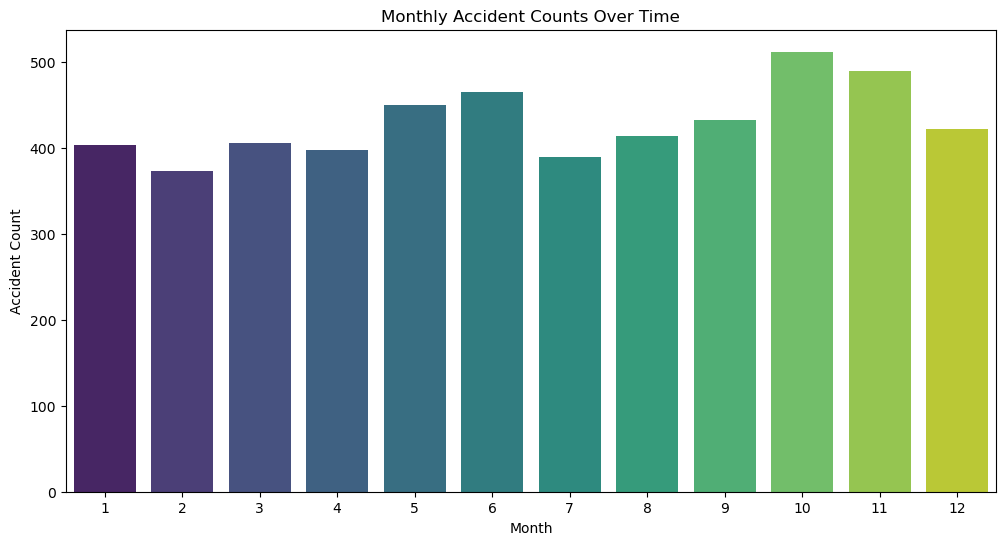

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.countplot(x='month', data=df, palette='viridis')
plt.title('Monthly Accident Counts Over Time')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.show()


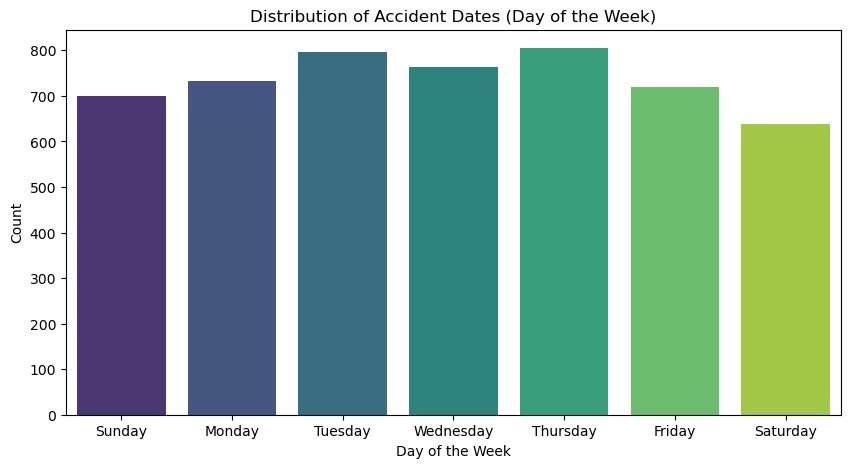

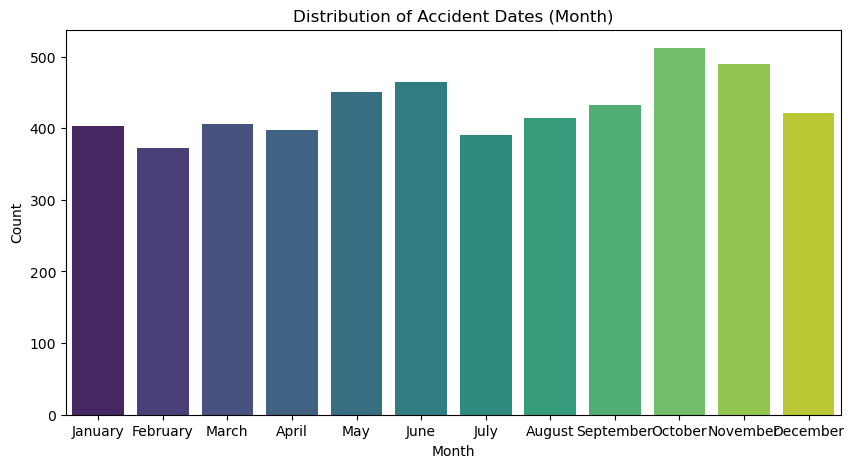

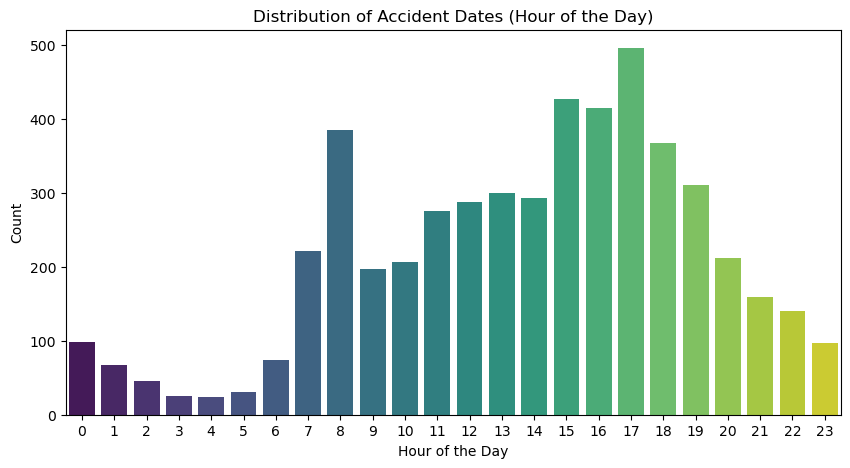

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


days_of_week_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
months_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


plt.figure(figsize=(10, 5))
sns.countplot(x='day_of_week', data=df, palette='viridis')
plt.title('Distribution of Accident Dates (Day of the Week)')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(ticks=range(7), labels=days_of_week_labels)  # Set custom labels for days of the week
plt.show()


plt.figure(figsize=(10, 5))
sns.countplot(x='month', data=df, palette='viridis')
plt.title('Distribution of Accident Dates (Month)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(ticks=range(12), labels=months_labels)  # Set custom labels for months
plt.show()


plt.figure(figsize=(10, 5))
sns.countplot(x='hour_of_day', data=df, palette='viridis')
plt.title('Distribution of Accident Dates (Hour of the Day)')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.show()


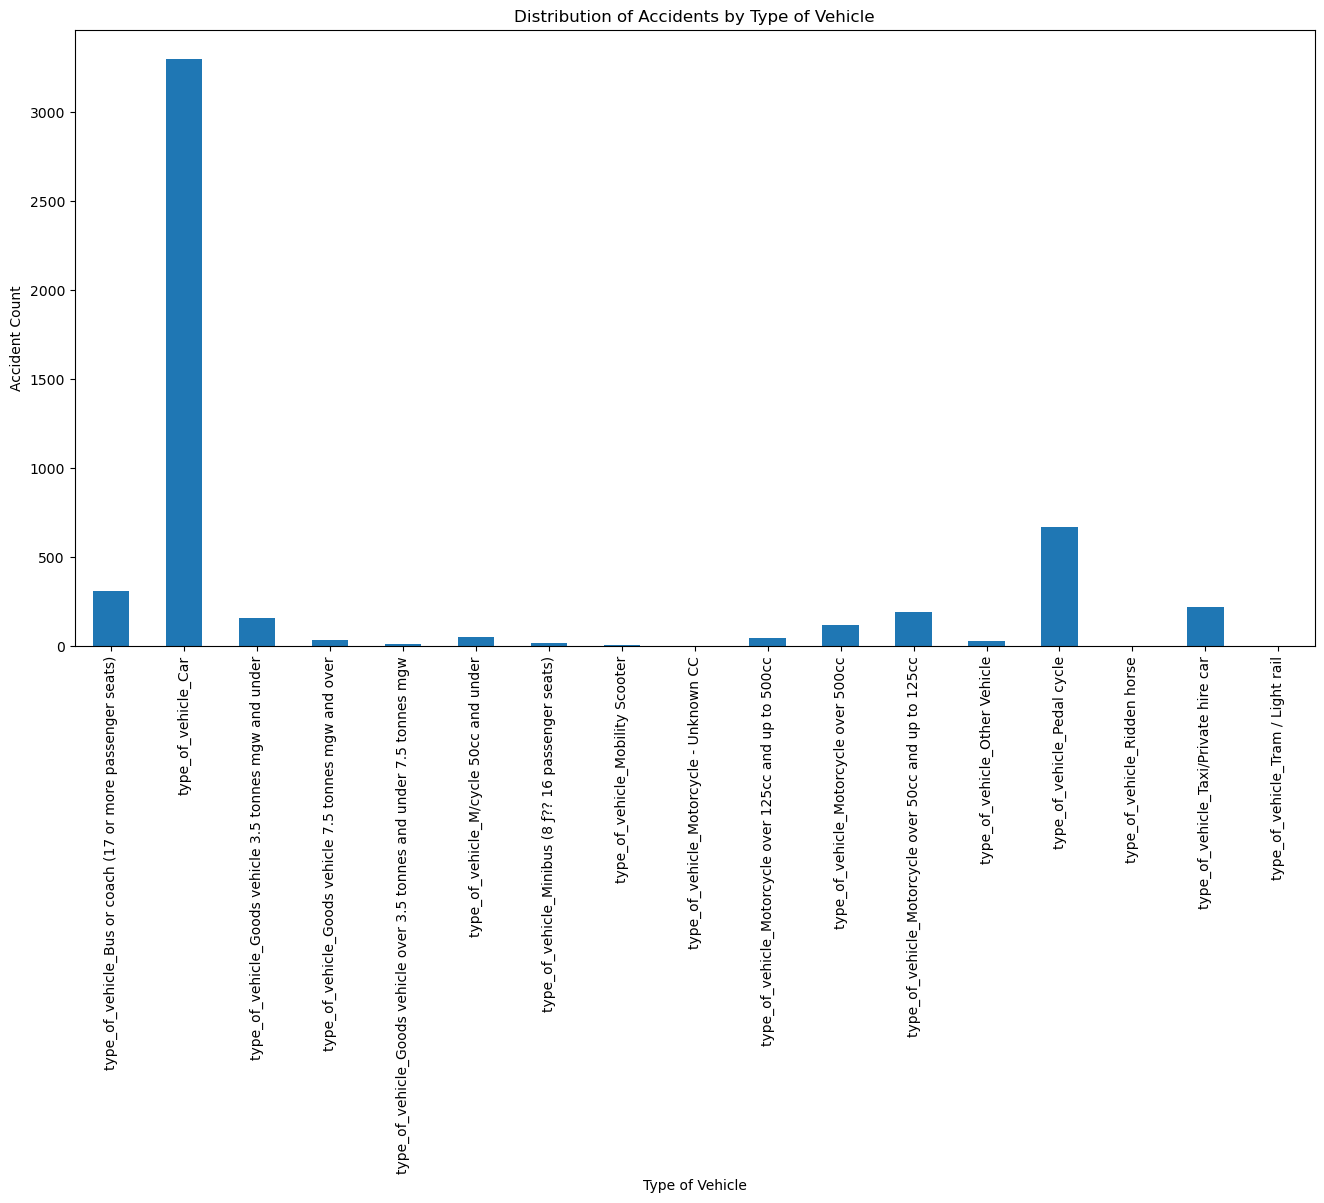

In [13]:
vehicle_cols = df.columns[df.columns.str.startswith('type_of_vehicle_')]

plt.figure(figsize=(16, 8))
df[vehicle_cols].sum().plot(kind='bar')
plt.title('Distribution of Accidents by Type of Vehicle')
plt.xlabel('Type of Vehicle')
plt.ylabel('Accident Count')
plt.xticks(rotation=90, ha='center')  
plt.show()